### MPI setup
* `ipyparallel` is used to start an IPython kernel 
* `mpi4py` is used like in regular `.py` scripts to handle MPI communication

In [1]:
import ipyparallel as ipp
cluster = ipp.Cluster(engines="mpi", n=4).start_and_connect_sync()

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

In [2]:
%%px
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
print(f"Process {rank} of {size} is running")

[stdout:0] Process 0 of 4 is running


[stdout:1] Process 1 of 4 is running


[stdout:2] Process 2 of 4 is running


[stdout:3] Process 3 of 4 is running


Import packages as usual, now starting with the magic `%%px` to execute it in all MPI ranks

In [3]:
%%px
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

from tqdm import tqdm

### Domain setup:
* __Capital variables__ are used as a convention to designate GLOBAL domain quantities: `NZ`, `ZMIN`, `ZMAX`
* __Lower case variables__ `Nz`, `zmin`, `zmax` will be associated to MPI subdomains and will be different for each `rank`. 
    * This quantities will be computed inside `GridFIT3D` when `use_mpi=True`

In [4]:
%%px
# ---------- Domain setup ---------
# Geometry & Materials
solid_1 = 'notebooks/data/002_vacuum_cavity.stl'
solid_2 = 'notebooks/data/002_lossymetal_shell.stl'

stl_solids = {'cavity': solid_1, 
              'shell': solid_2
              }

stl_materials = {'cavity': 'vacuum', 
                 'shell': [30, 1.0, 30] #[eps_r, mu_r, sigma[S/m]]
                 }

# Extract domain bounds from geometry
solids = pv.read(solid_1) + pv.read(solid_2)
xmin, xmax, ymin, ymax, ZMIN, ZMAX = solids.bounds

# Number of mesh cells
Nx = 80
Ny = 80
NZ = 141

In [5]:
%%px
grid = GridFIT3D(xmin, xmax, ymin, ymax, ZMIN, ZMAX, 
                Nx, Ny, NZ, 
                use_mpi = True,
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0,
                stl_rotate=[0,0,0],
                stl_translate=[0,0,0],
                verbose=1)
                
print(f"Process {rank}: Handling Z range {grid.zmin} to {grid.zmax} with {grid.Nz} cells")

[stdout:0] MPI initialized for 0 of 4
Generating grid...
Importing stl solids...
Process 0: Handling Z range -0.25 to -0.044285711220332556 with 36 cells


[stdout:3] MPI initialized for 3 of 4
Generating grid...
Importing stl solids...
Process 3: Handling Z range 0.3442857231412615 to 0.550000011920929 with 36 cells


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stdout:1] MPI initialized for 1 of 4
Generating grid...
Importing stl solids...
Process 1: Handling Z range -0.055714282819202966 to 0.15571429175989968 with 37 cells


[stdout:2] MPI initialized for 2 of 4
Generating grid...
Importing stl solids...
Process 2: Handling Z range 0.14428572016102928 to 0.35571429474013194 with 37 cells


### Solver definition
* We define our solver as for a non-MPI simulation, just passing `use_mpi=True`

In [6]:
%%px
# boundary conditions
bc_low=['pec', 'pec', 'pec']
bc_high=['pec', 'pec', 'pec']

# Solver setup
solver = SolverFIT3D(grid,
                    bc_low=bc_low, 
                    bc_high=bc_high, 
                    use_stl=True,
                    use_mpi=True, 
                    bg='pec' # Background material
                    )

# image folder creation
img_folder = 'notebooks/005_img/'
if not os.path.exists(img_folder): 
    os.mkdir(img_folder)

[stdout:0] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.5237085819244385 s


[stdout:1] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.5584671497344971 s


[stdout:3] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.53904128074646 s


[stdout:2] Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 0.5827789306640625 s


We can visualize our conductivity tensor $\sigma$ for each rank subdomain:

[output:1]

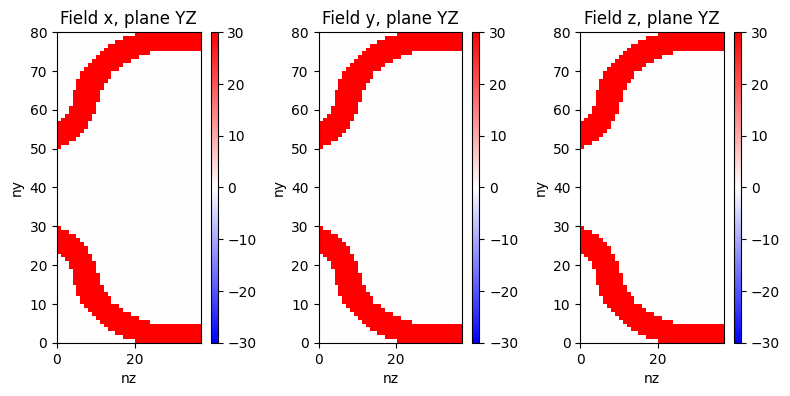

[output:0]

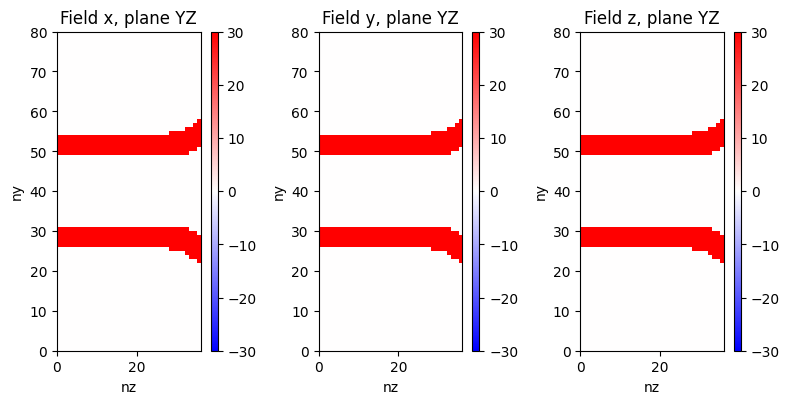

[output:2]

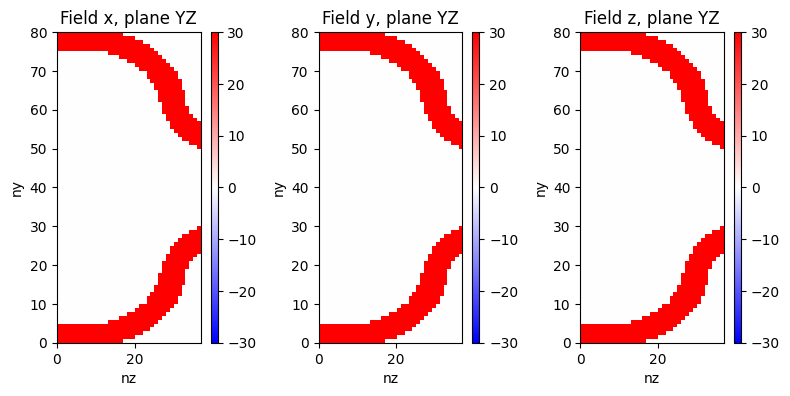

[output:3]

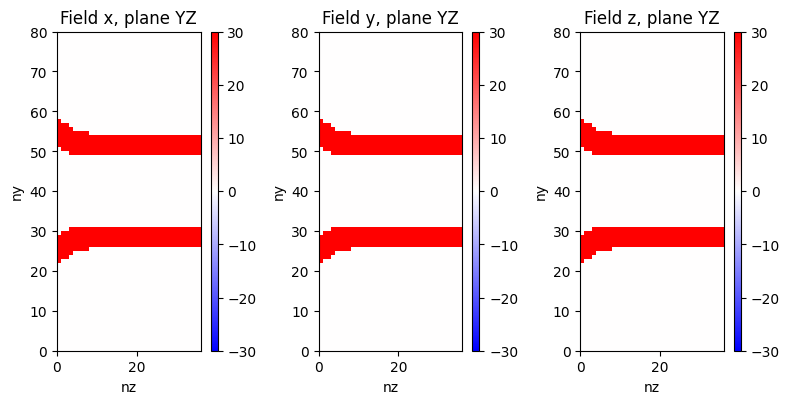

In [7]:
%%px
for n in range(size):
    if rank==n:
        solver.sigma.inspect()

We generate our beam source as per a non-MPI simulation:

In [8]:
%%px
# ------------ Beam source & Wake ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 

# Simualtion
wakelength = 10. # [m]
add_space = 10   # no. cells to skip from boundaries - removes BC artifacts

from wakis.sources import Beam
from scipy.constants import c
beam = Beam(q=q, sigmaz=sigmaz, beta=beta,
            xsource=xs, ysource=ys, ti=3*sigmaz/c)

## Custom Time loop with on-the-fly plotting
* We can run our simulation as usual, only changing the field advance to `mpi_one_step()`

In [36]:
%%px
n = 0
solver.reset_fields()

plot_inspect = False
plot_2D = True
plot_1D = False

In [37]:
%%px
Nt = 3000
for n in tqdm(range(Nt)):
    
    beam.update(solver, n*solver.dt)

    solver.mpi_one_step()
    
    # Plot inspect every 20 timesteps
    if n%20 == 0 and plot_inspect:
        E = solver.mpi_gather_asField('E')
        if rank == 0:
            fig, ax = E.inspect(figsize=[20,6], plane='YZ', show=False, handles=True)
            fig.savefig(img_folder+'Einspect_'+str(n).zfill(4)+'.png')
            plt.close(fig)

    # Plot E abs in 2D every 20 timesteps
    if n%20 == 0 and plot_2D:
        solver.plot2D(field='E', component='Abs', 
                    plane='YZ', pos=0.5, 
                    cmap='rainbow', vmin=0, vmax=500., interpolation='hanning',
                    off_screen=True, title=img_folder+'Ez2d', n=n)

    # Plot E z in 1D at diferent transverse positions `pos` every 20 timesteps
    if n%20 == 0 and plot_1D:
        solver.plot1D(field='E', component='z', 
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=True, title=img_folder+'Ez1d', n=n)

[stderr:1] 100%|██████████| 3000/3000 [01:52<00:00, 26.68it/s]


[stderr:0] 100%|██████████| 3000/3000 [01:52<00:00, 26.68it/s]


[stderr:3] 100%|██████████| 3000/3000 [01:52<00:00, 26.68it/s]


[stderr:2] 100%|██████████| 3000/3000 [01:52<00:00, 26.68it/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

### Post-processing
* We can generate a `GIF` animation from a notebook cell and display it in the notebook:

In [38]:
!convert -delay 10 -loop 0 notebooks/005_img/E*.png notebooks/005_img/005_E.gif
!rm notebooks/005_img/E*.png

In [44]:
from IPython.display import HTML
HTML('<img src="005_img/005_E.gif">')

* We can also plot the last timestep's fields `E`, `H` or `J`

[output:0]

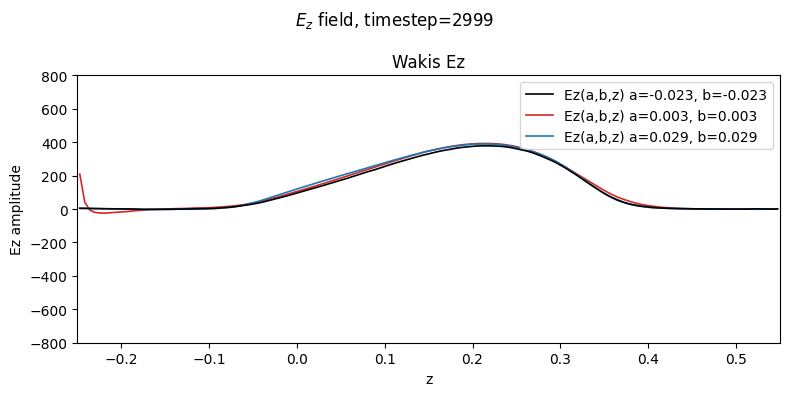

In [45]:
%%px
solver.plot1D(field='E', component='z', 
              line='z', pos=[0.45, 0.5, 0.55], ylim=(-800, 800),
              xscale='linear', yscale='linear',
              off_screen=False, title=img_folder+'Ez1d', n=n)

[output:0]

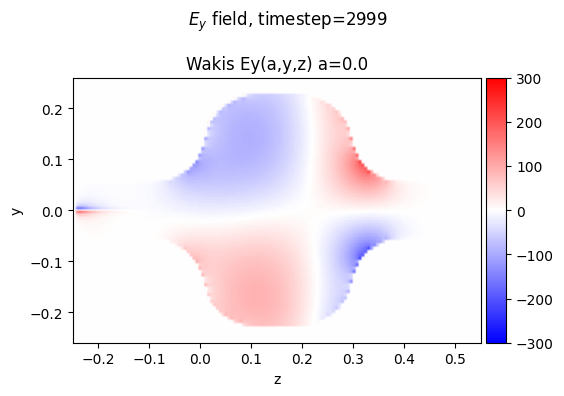

In [46]:
%%px
solver.plot2D(field='E', component='y', 
            plane='YZ', pos=0.5, 
            cmap='bwr', vmin=-300, vmax=300., interpolation='hanning',
            off_screen=False, title=img_folder+'Ez2d', n=n)

[output:0]

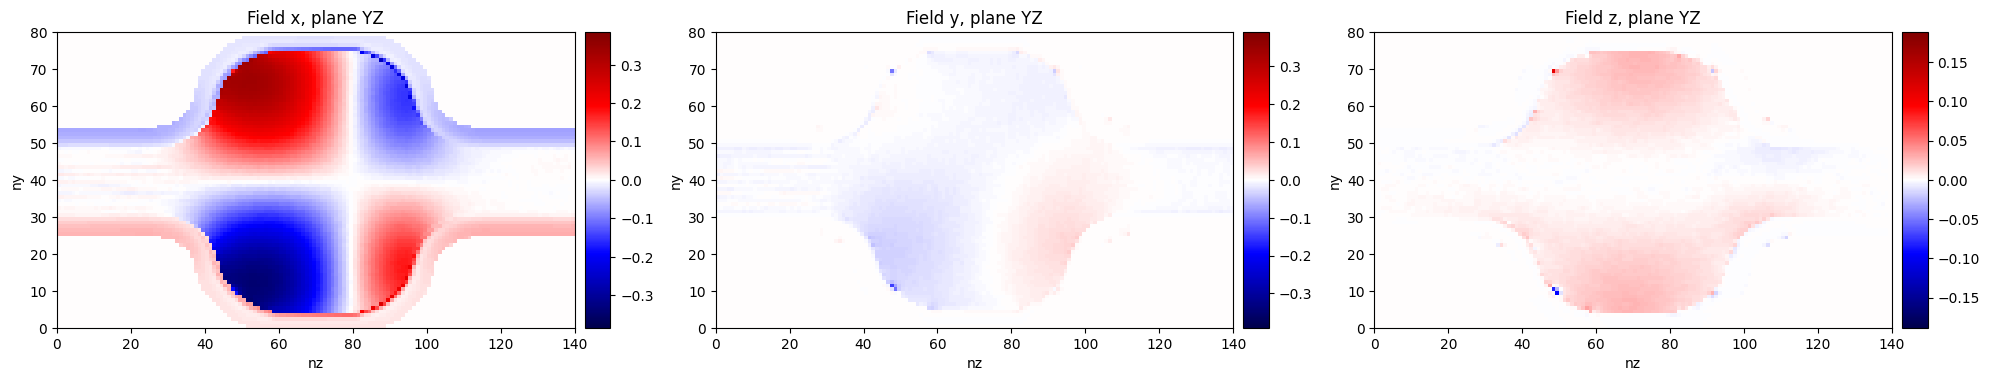

In [47]:
%%px
#gathers H field as a Field object to rank=0
H = solver.mpi_gather_asField('H') 

# only plot in rank 0 where H has been gathered
if rank == 0: 
    fig, ax = H.inspect(figsize=[20,6], cmap='seismic', plane='YZ', show=False, handles=True)
    plt.show()

## Wakefield simulation

In [9]:
%%px
n = 0
solver.reset_fields()

First we need to set up the wake object:

In [ ]:
%%px
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = 10   # no. cells to skip at zlo/zhi for wake integration
results_folder = '005_results/'
wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                skip_cells=10,
                results_folder=results_folder,
                Ez_file=results_folder+'Ez.h5',)

Now we can run the wakefield simulation by doing:

In [11]:
%%px
solver.wakesolve(wakelength=wakelength, 
                 wake=wake, 
                 plot=False)

[stdout:2] Running electromagnetic time-domain simulation...


[stdout:3] Running electromagnetic time-domain simulation...


[stderr:2] 100%|██████████| 6505/6505 [03:06<00:00, 34.80it/s]


[stderr:3] 100%|██████████| 6505/6505 [03:06<00:00, 34.80it/s]


[stdout:1] Running electromagnetic time-domain simulation...


[stderr:1] 100%|██████████| 6505/6505 [03:06<00:00, 34.80it/s]


[stdout:0] Running electromagnetic time-domain simulation...
Reading h5 file results/001_Ez.h5
Calculating longitudinal wake potential WP(s)
Calculating transverse wake potential WPx, WPy...
Calculating longitudinal impedance Z...
Calculating transverse impedance Zx, Zy...


100%|██████████| 54558/54558 [00:00<00:00, 89489.90it/s]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

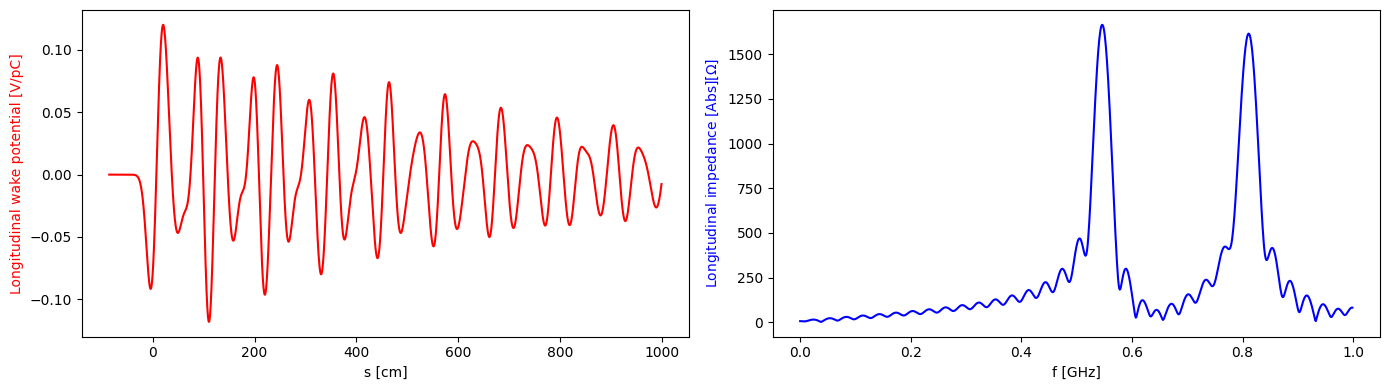

In [25]:
%%px
if solver.rank == 0:
    fig, ax = plt.subplots(1,2, figsize=[14,4], dpi=100)
    ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
    ax[0].set_xlabel('s [cm]')
    ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

    ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
    ax[1].set_xlabel('f [GHz]')
    ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

    fig.tight_layout()

### Extrapolating to fully decayed impedance with `iddefix`

In [16]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../IDDEFIX/')

import iddefix
from wakis import WakeSolver
from scipy.constants import c

Load previously computed results:

In [17]:
results_folder='results'
wake = WakeSolver()
wake.load_results(results_folder)

Fin the bounds of the resonators to feed the differential evolution

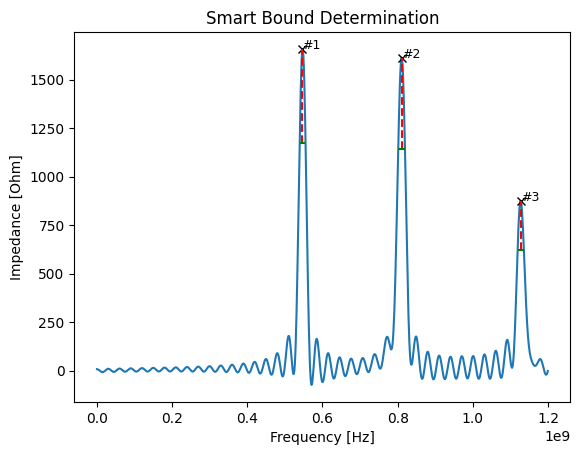


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |  1327.28 to 16590.97   | 18.92 to 189.17  |  5.37e+08 to 5.57e+08   
    2     |  1291.35 to 16141.85   | 24.04 to 240.36  |  8.01e+08 to 8.21e+08   
    3     |   700.53 to 8756.64    | 33.43 to 334.29  |  1.12e+09 to 1.14e+09   
--------------------------------------------------------------------------------


In [18]:
# Compute impedance through deconvolution
# To improve algorithm speed and convergence, it is advised to keep the data to about 1000 samples
f,Z = iddefix.compute_deconvolution(wake.s/c, wake.WP*1e12/c, samples=1000, fmax=1.2e9, sigma=10e-2/c)
Z *= -1.0 # longitudinal impedance normalization

# Control the heigths to be passed to the peak finder routine
heights = np.zeros_like(Z)
heights[:] = 450
heights[np.logical_and(f>0.70e9,f<0.8e9)] = 3000

bounds = iddefix.SmartBoundDetermination(f, np.real(Z), 
                                        Rs_bounds=[0.8, 10],    # bound multipliers for peak Rs
                                        Q_bounds=[0.5, 5],      # bound multipliers for estimated Q
                                        fres_bounds=[-0.01e9, +0.01e9]) # bound margins for estimated fres

bounds.find(minimum_peak_height=heights, distance=10 )
bounds.inspect()        # plot the found peaks and estimated Q
bounds.to_table()       # print as a table the estimated bounds


Run the differential evolution:

In [19]:
DE_model = iddefix.EvolutionaryAlgorithm(f, 
                                         Z.real, 
                                         N_resonators=bounds.N_resonators, 
                                         parameterBounds=bounds.parameterBounds,
                                         plane='longitudinal',
                                         fitFunction='impedance', 
                                         wake_length=wake.s[-1], # in [m]
                                         objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal
                                         ) 

# Run the differential evolution
DE_model.run_differential_evolution(maxiter=30000,
                                    popsize=150,
                                    tol=0.001,
                                    mutation=(0.3, 0.8),
                                    crossover_rate=0.5)
print(DE_model.warning)

[!] Using the partially decayed resonator formalism for impedance


Optimization Progress %: 100.64514637620296it [00:35,  2.80it/s]                             



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.45e+03        |      50.11       |    5.469e+08     
    2     |        1.99e+03        |      48.92       |    8.102e+08     
    3     |        1.06e+03        |      69.68       |    1.128e+09     
----------------------------------------------------------------------
callback function requested stop early


Locally improve the result with a minimization step:

In [20]:
DE_model.run_minimization_algorithm()

Method for minimization : Nelder-Mead


----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        2.44e+03        |      50.00       |    5.469e+08     
    2     |        1.99e+03        |      48.88       |    8.102e+08     
    3     |        1.06e+03        |      69.82       |    1.128e+09     
----------------------------------------------------------------------


Asses the fitting done by the differential evolution:

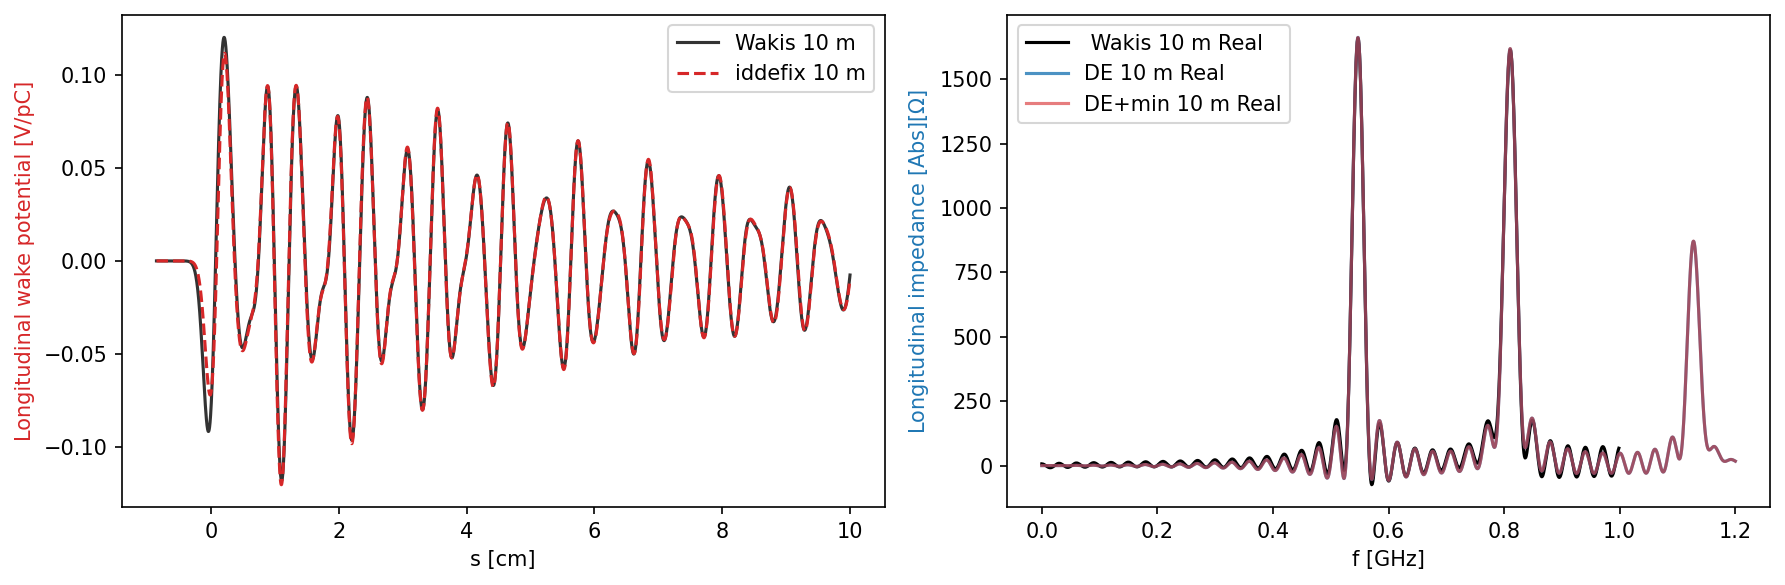

In [33]:
# Retrieve partially decayed wake portential (30 m)
WP_pd = DE_model.get_wake_potential(wake.s/c, sigma=10e-2/c)

# Retreieve partially decayed  fittted impedance
f_pd = np.linspace(0, 1.2e9, 10000)
Z_pd = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=False)  # use only evolutionary parameters
Z_pd_min = DE_model.get_impedance_from_fitFunction(f_pd, use_minimization=True) # use minimization parameters

# Plot comparison
fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8,label='Wakis 10 m')
ax[0].plot(wake.s, -WP_pd*1e-12, c='tab:red', lw=1.5, label='iddefix 10 m', ls='--')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='-', c='k', lw=1.5, label=' Wakis 10 m Real')
ax[1].plot(f_pd*1e-9, np.real(Z_pd), ls='-', c='tab:blue', alpha=0.8, lw=1.5, label='DE 10 m Real')
ax[1].plot(f_pd*1e-9, np.real(Z_pd_min), ls='-', c='tab:red', alpha=0.6, lw=1.5, label='DE+min 10 m Real')

ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()

Plot the fully decayed impedance:

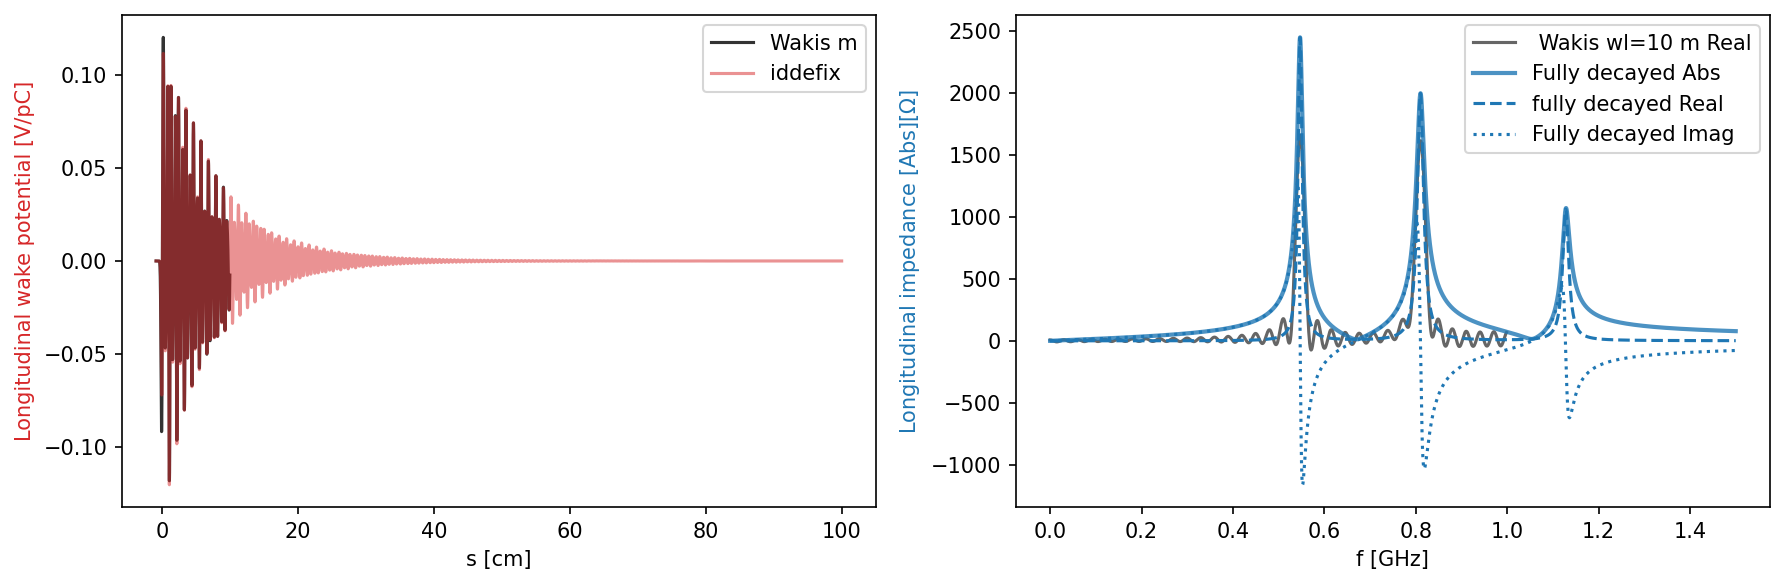

In [35]:
# Fully decayed wake, wakelength 1000 m
s_fd = np.linspace(wake.s[0], 100, 10000)
WP_fd = DE_model.get_wake_potential(s_fd/c, sigma=10e-2/c)

# Fully decayed wake, wakelength inf m
f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)

# Plot
fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(wake.s, wake.WP, c='k', alpha=0.8,label='Wakis m')
ax[0].plot(s_fd, -WP_fd*1e-12, c='tab:red', lw=1.5, alpha=0.5, label='iddefix')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(wake.f*1e-9, np.real(wake.Z), ls='-', c='k', alpha=0.6, lw=1.5, label=' Wakis wl=10 m Real')
ax[1].plot(f_fd*1e-9, np.abs(Z_fd), c='tab:blue', alpha=0.8, lw=2, label='Fully decayed Abs')
ax[1].plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:blue', lw=1.5, label='fully decayed Real')
ax[1].plot(f_fd*1e-9, np.imag(Z_fd), ls=':', c='tab:blue', lw=1.5, label='Fully decayed Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()